# FINE TUNING STABLE DIFFUSION (SD) FOR PIXEL ART GENERATION

Our goal here is to use stable diffusion to generate pixel art from drawings by moving the drawing into the SD latent space, which is very good at capturing the structure of the image. Then we enforce it's output to be pixelart-like by limiting the pixels and color palette. It is like using the best possible VAE, and will be used as a baseline for comparison with other methods.

This works well because a traditional VAE would need to be trained with direct pairs of drawings/pixelart (which are incredibly hard to find man-made, and taking artificial ones would essentially be training a model with DALL-E or SD input, which would be kind of cheating and using SD anyway).

We aim to use domain adaptation or conditional training to enforce a certain behaviour from SD.

Core ideas/techniques:

	1.	Conditioning Input: Use drawings as the conditioning input for generating pixel art.
	2.	Loss Functions: Leverage losses that work with unpaired data, such as:
	    •	Adversarial Loss: Encourage realism in pixel art outputs.
	    •	Style Loss: Match the pixel art style distribution.
	    •	Cycle-Consistency Loss: Ensure the transformation is reversible.

## 0.Preliminary checks

In [1]:
import torch
def get_device():
    if torch.cuda.is_available():
        print("Using CUDA (NVIDIA GPU)")
        return torch.device("cuda")
    elif torch.backends.mps.is_available():
        print("Using MPS (Apple Silicon GPU)")
        return torch.device("mps")
    else:
        print("Falling back to CPU")
        return torch.device("cpu")

device = get_device()


import os

def is_colab():
  """
  Checks if the code is running in a Google Colab environment.

  Returns:
    True if running in Colab, False otherwise.
  """
  return 'COLAB_GPU' in os.environ or 'COLAB_TPU_ADDR' in os.environ

from google.colab import drive

if is_colab():
  print("Running in Colab")
  # Set the colab path where dataset is stored
  notebook_root = "/content/drive/MyDrive/draw2pix_colab/notebooks/"
  # Mount Google Drive (if not mounted already)
  if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')
else:
  print("Not running in Colab")
  project_root = "../"

Using CUDA (NVIDIA GPU)
Running in Colab


## 1. Prepare the Dataset

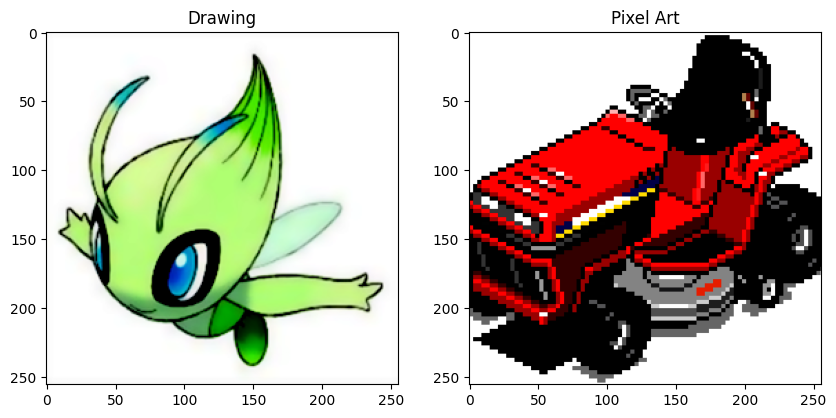

In [2]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
import torchvision.transforms as T

class UnpairedDataset(Dataset):
    def __init__(self, drawings_dir, pixel_art_dir, img_size=256):
        self.drawings = [os.path.join(drawings_dir, f) for f in os.listdir(drawings_dir)]
        self.pixel_art = [os.path.join(pixel_art_dir, f) for f in os.listdir(pixel_art_dir)]
        self.transform = T.Compose([
            T.Resize((img_size, img_size)),
            T.ToTensor(),
            T.Normalize([0.5], [0.5])  # Normalize to [-1, 1]
        ])

    def __len__(self):
        return max(len(self.drawings), len(self.pixel_art))

    def __getitem__(self, idx):
        drawing = Image.open(self.drawings[idx % len(self.drawings)]).convert("RGB")
        pixel_art = Image.open(self.pixel_art[idx % len(self.pixel_art)]).convert("RGB")
        return self.transform(drawing), self.transform(pixel_art)

# Load the dataset

drawing_path  = notebook_root + "../dataset/draw2pix/Non-pixel art"
pixel_art_path = notebook_root + "../dataset/draw2pix/Multi-cell pixel art"

dataset = UnpairedDataset(drawing_path, pixel_art_path)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

# Display a random image from the path
import matplotlib.pyplot as plt

def display_random_image(dataset):
    idx = torch.randint(0, len(dataset), (1,)).item()
    drawing, pixel_art = dataset[idx]
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(drawing.permute(1, 2, 0))
    axs[0].set_title('Drawing')

    axs[1].imshow(pixel_art.permute(1, 2, 0))
    axs[1].set_title('Pixel Art')
    plt.show()

display_random_image(dataset)

## 2. Fine-tuning

In [3]:
import os
import torch
print(torch.__version__)
import torch.nn.functional as F
from diffusers import StableDiffusionPipeline
from torch.optim import AdamW
from torch.utils.data import DataLoader
from time import time
from torch.amp import GradScaler, autocast

2.5.1+cu121


In [ ]:
# Load pre-trained Stable Diffusion
model_name = "CompVis/stable-diffusion-v1-4"
pipeline = StableDiffusionPipeline.from_pretrained(model_name).to(device)

# Optimizer and scaler
optimizer = AdamW(pipeline.unet.parameters(), lr=1e-5)
scaler = GradScaler()

# Checkpoint directory
checkpoint_dir = "/content/checkpoints/draw2pix/SD_fine_tuning"
os.makedirs(checkpoint_dir, exist_ok=True)

# Load checkpoint if available
start_epoch = 0
checkpoint_path = os.path.join(checkpoint_dir, "latest_checkpoint.pth")
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    pipeline.unet.load_state_dict(checkpoint["unet_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    start_epoch = checkpoint["epoch"] + 1
    print(f"Resuming training from epoch {start_epoch}...")

# Training Loop
num_epochs = 10
start_time = time()
from torch.cuda.amp import GradScaler, autocast

scaler = GradScaler()

for epoch in range(num_epochs):
    for i, (drawings, pixel_art) in enumerate(dataloader):
        drawings, pixel_art = drawings.to(device), pixel_art.to(device)

        optimizer.zero_grad()
        with autocast():
            # Encode images to latent space
            latent_drawings = pipeline.vae.encode(drawings).latent_dist.sample()
            latent_pixel_art = pipeline.vae.encode(pixel_art).latent_dist.sample()
            timestep = torch.randint(0, 1000, (latent_drawings.shape[0],), device=device)

            # Tokenize text inputs
            text_inputs = ["pixel art of a drawing"] * latent_drawings.shape[0]
            text_tokens = pipeline.tokenizer(
                text_inputs,
                padding="max_length",
                max_length=pipeline.tokenizer.model_max_length,
                truncation=True,
                return_tensors="pt"
            ).input_ids.to(device)

            # Generate encoder_hidden_states
            encoder_hidden_states = pipeline.text_encoder(text_tokens).last_hidden_state

            # Forward pass
            gen_pixel_art_latents = pipeline.unet(
                latent_drawings,
                timestep=timestep,
                encoder_hidden_states=encoder_hidden_states,
            ).sample

            # Compute loss
            loss = F.mse_loss(gen_pixel_art_latents, latent_pixel_art)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        if i % 10 == 0:
            print(f"Epoch {epoch + 1}/{num_epochs}, Batch {i}/{len(dataloader)}, Loss: {loss.item():.4f}")


    # Save checkpoint after each epoch
    checkpoint = {
        "epoch": epoch,
        "unet_state_dict": pipeline.unet.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
    }
    torch.save(checkpoint, checkpoint_path)
    print(f"Checkpoint saved at epoch {epoch + 1}.")

    # Save intermediate model
    intermediate_model_path = os.path.join(
        checkpoint_dir, f"stable_diffusion_epoch_{epoch}.pth"
    )
    pipeline.unet.save_pretrained(intermediate_model_path)
    print(f"Intermediate model saved: {intermediate_model_path}")

# Final Save
final_model_path = os.path.join(checkpoint_dir, "stable_diffusion_final")
pipeline.save_pretrained(final_model_path)
print(f"Training complete. Final model saved at {final_model_path}.")

2.5.1+cu121


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

<ipython-input-4-4671cebccdd6>:41: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
<ipython-input-4-4671cebccdd6>:48: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/10, Batch 0/875, Loss: 24.3813
Epoch 1/10, Batch 10/875, Loss: 25.4824
Epoch 1/10, Batch 20/875, Loss: 24.4477
Epoch 1/10, Batch 30/875, Loss: 23.6885
Epoch 1/10, Batch 40/875, Loss: 27.9569
Epoch 1/10, Batch 50/875, Loss: 21.9320
Epoch 1/10, Batch 60/875, Loss: 26.6585
Epoch 1/10, Batch 70/875, Loss: 22.5114
Epoch 1/10, Batch 80/875, Loss: 23.7978
Epoch 1/10, Batch 90/875, Loss: 24.3778
Epoch 1/10, Batch 100/875, Loss: 22.3867
Epoch 1/10, Batch 110/875, Loss: 21.5872
Epoch 1/10, Batch 120/875, Loss: 23.0417
Epoch 1/10, Batch 130/875, Loss: 21.6451
Epoch 1/10, Batch 140/875, Loss: 22.5426
Epoch 1/10, Batch 150/875, Loss: 21.3651
Epoch 1/10, Batch 160/875, Loss: 23.7510
Epoch 1/10, Batch 170/875, Loss: 24.9025
Epoch 1/10, Batch 180/875, Loss: 21.8483
Epoch 1/10, Batch 190/875, Loss: 27.8559
Epoch 1/10, Batch 200/875, Loss: 19.7258
Epoch 1/10, Batch 210/875, Loss: 21.6831
Epoch 1/10, Batch 220/875, Loss: 21.7247
Epoch 1/10, Batch 230/875, Loss: 22.9245
Epoch 1/10, Batch 240/875, 

In [40]:
import torch
import matplotlib.pyplot as plt


def generate_pixel_art(drawing, model, text="pixel art of a drawing"):
    """
    Generate pixel art from a drawing using the fine-tuned Stable Diffusion model.
    Args:
        drawing: Tensor of shape (1, 3, H, W) representing the drawing.
        model: Loaded PyTorch model.
        text: Text prompt to condition the generation.
    Returns:
        Tensor of shape (1, 3, H, W) representing the generated pixel art.
    """
    drawing = drawing.to(device)
    # We use the StableDiffusionPipeline class to load the model, it was saved with it, it's features can probably be extracted to create a new smaller class.
    #model = StableDiffusionPipeline.from_pretrained(model_path).to(device)

    # Mock-up latent encoding and text conditioning for illustration only
    # Replace with appropriate logic matching your model's implementation
    latent_drawing = model.vae.encode(drawing).latent_dist.sample()
    timestep = torch.randint(0, 1000, (1,), device=device)

    # Tokenize text input
    text_tokens = model.tokenizer(
        [text],
        padding="max_length",
        max_length=model.tokenizer.model_max_length,
        truncation=True,
        return_tensors="pt"
    ).input_ids.to(device)

    # Generate encoder_hidden_states
    encoder_hidden_states = model.text_encoder(text_tokens).last_hidden_state

    # Forward pass
    with torch.no_grad():
        gen_pixel_art_latents = model.unet(
            latent_drawing,
            timestep=timestep,
            encoder_hidden_states=encoder_hidden_states,
        ).sample

    return model.vae.decode(gen_pixel_art_latents).sample.detach()

#Load fine tuned model
sd_final_path = "checkpoints/draw2pix/SD_fine_tuning/stable_diffusion_final"
pipeline = StableDiffusionPipeline.from_pretrained(sd_final_path).to(device)


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

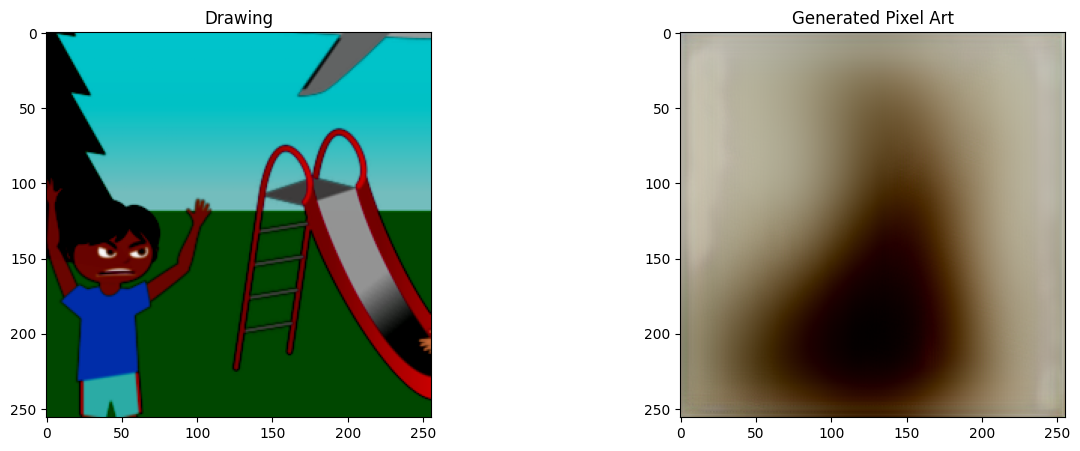

In [44]:
# Load a random drawing
idx = torch.randint(0, len(dataset), (1,)).item()
drawing, _ = dataset[idx]

# Generate pixel art from the loaded model
generated_pixel_art = generate_pixel_art(drawing.unsqueeze(0), pipeline, "")

# Display the results
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].imshow(drawing.permute(1, 2, 0))
axs[0].set_title('Drawing')
axs[1].imshow(generated_pixel_art.squeeze(0).permute(1, 2, 0).cpu().numpy())
axs[1].set_title('Generated Pixel Art')
plt.show()